In [1]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import pdb
import requests
import matplotlib.pyplot as plt
from collections import defaultdict
import random 
import time

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import *

from functools import wraps
from time import time as _timenow 
from sys import stderr

## Load CIFAR-10 Data

In [2]:
def load_cifar():
    
    trn_data, trn_labels, tst_data, tst_labels = [], [], [], []
    def unpickle(file):
        with open(file, 'rb') as fo:
            data = pickle.load(fo, encoding='latin1')
        return data
    
    for i in trange(1):
        batchName = './data/data_batch_{0}'.format(i + 1)
        unpickled = unpickle(batchName)
        trn_data.extend(unpickled['data'])
        trn_labels.extend(unpickled['labels'])
    unpickled = unpickle('./data/test_batch')
    tst_data.extend(unpickled['data'])
    tst_labels.extend(unpickled['labels'])
    return trn_data, trn_labels, tst_data, tst_labels


## Image preprocessing

In [3]:
def image_prep(image):
    processed_image = image
#     m = np.mean(image, axis=0)
#     sd = np.std(image, axis=0)
#     processed_image = image - m
#     processed_image = processed_image/sd
    ''' pre-processes the given image
        performs mean normalization and other such operations'''
    return processed_image

## Dimensionality reduction using PCA

In [4]:
def reduce_dim(**kwargs):
    dim = kwargs['dim']
    train_X = kwargs['train_X']
    train_y = kwargs['train_y']
    ''' performs dimensionality reduction'''
    if kwargs['method'] == 'pca':
        pca = PCA(n_components=dim)
        pca.fit(train_X)
        X_reduced = pca.transform(train_X)
        return pca, X_reduced
    
    if kwargs['method'] == 'lda':
        lda = LinearDiscriminantAnalysis(n_components=dim)
        lda.fit(train_X,train_y)
        X_reduced = lda.transform(train_X)
        return lda, X_reduced        
    
    if kwargs['method'] == 'kpca':
        kpca = KernelPCA(n_components=dim, kernel='rbf',n_jobs = -1)
        X_reduced = kpca.fit_transform(train_X)
        return kpca, X_reduced

## Classification using kernel SVM

In [5]:
def classify(X, y, **kwargs):
    ''' trains a classifier by taking input features
        and their respective targets and returns the trained model'''
    if kwargs['method'] == 'Logistic Regression':
        clf = LogisticRegression(solver='lbfgs',multi_class='multinomial')
        clf = clf.fit(X, y)
        return clf
    if kwargs['method'] == 'Decision Tree':
        clf = tree.DecisionTreeClassifier()
        clf = clf.fit(X, y)
        return clf
    if kwargs['method'] == 'MLP':
        clf = MLPClassifier()
        clf = clf.fit(X, y)
        return clf

## Evaluation 

In [6]:
def evaluate(target, predicted):
    f1 = f1_score(target, predicted, average='micro')
    acc = accuracy_score(target, predicted)
    return f1, acc

In [7]:
def test(**kwargs):
    classifer_model = kwargs['classifer_model']
    test_X = kwargs['test_X']
    test_y = kwargs['test_y']
    predicted_y = classifer_model.predict(test_X)
    f1, acc = evaluate(test_y, predicted=predicted_y)
    print(f1)
    print(acc)
    return f1, acc

In [8]:
dec_PCA_acc = []
dec_PCA_f1 = []
def main1():
    trn_data, trn_labels, tst_data, tst_labels = load_cifar()
    trn_data, tst_data = list(map(image_prep, trn_data)), list(map(image_prep, tst_data))
    X_train, X_val, y_train, y_val = train_test_split(trn_data, trn_labels,test_size = 0.20)
    scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
    X_train = scaling.transform(X_train)
    X_val = scaling.transform(X_val)

    dims=[1,2,4,8,16,32,64,128,256,512,1024]
    for dim in dims:
        print(dim)
        reduced_model, X_reduced = reduce_dim(method='kpca',dim=dim,train_X = X_train,train_y = y_train)
        classifer_model = classify(X_reduced, y_train, method='MLP')
        test_X_reduced = reduced_model.transform(X_val)
        f1, acc = test(classifer_model=classifer_model,test_X = test_X_reduced, test_y = y_val)
        dec_PCA_acc.append(acc)
        dec_PCA_f1.append(f1)
    
    ''' perform dimesioality reduction/feature extraction and classify the features into one of 10 classses
        print accuracy and f1-score.
        '''
#     print('Val - F1 score: {}\n Accuracy: {}'.format(f_score, accuracy_))


In [9]:
if __name__ == '__main__':
    main1()

100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


1
0.167
0.167
2
0.22400000000000003
0.224
4


/home/kgarg/smai-18-mini-project-2/mypython/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.285
0.285
8


/home/kgarg/smai-18-mini-project-2/mypython/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.3605
0.3605
16


/home/kgarg/smai-18-mini-project-2/mypython/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.4035
0.4035
32


/home/kgarg/smai-18-mini-project-2/mypython/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.4485
0.4485
64


/home/kgarg/smai-18-mini-project-2/mypython/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.454
0.454
128


/home/kgarg/smai-18-mini-project-2/mypython/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.458
0.458
256


/home/kgarg/smai-18-mini-project-2/mypython/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.451
0.451
512


/home/kgarg/smai-18-mini-project-2/mypython/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.43799999999999994
0.438
1024


/home/kgarg/smai-18-mini-project-2/mypython/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.4195
0.4195


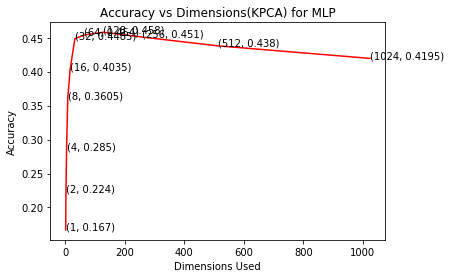

In [10]:
dims=[1,2,4,8,16,32,64,128,256, 512,1024]
for i in range(1,len(dec_PCA_acc)):
#     print(i)
    dec_PCA_f1[i] = round(dec_PCA_f1[i], 3)
#     print(i)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(dims,dec_PCA_acc,'r')
plt.xlabel('Dimensions Used')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Dimensions(KPCA) for MLP')
for xy in zip(dims, dec_PCA_acc):
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.savefig('finalMLP_KPCA_accuracy_1.svg',format='svg')

In [12]:
print(dims)
data = {'Dimensions' : dims,
        'Accuracy':dec_PCA_acc,
#         'Score':svm_PCA_f1
       }
p = pd.DataFrame(data)
columnsTitles=["Dimensions","Accuracy"]
p = p.reindex(columns=columnsTitles)
p.index = range(1,12)
# print(p)
# print(svm_PCA_f1)
p

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]


,Dimensions,Accuracy
1,1,0.1670
2,2,0.2240
3,4,0.2850
4,8,0.3605
5,16,0.4035
6,32,0.4485
7,64,0.4540
8,128,0.4580
9,256,0.4510
10,512,0.4380


In [7]:
def sethyperparam(X, y, **kwargs):
     if kwargs['method'] == 'MLP':
            max_iter = kwargs['max_iter']
            learning_rate = kwargs['learning_rate']
            hidden_layer_sizes = kwargs['hidden_layer_sizes']
            solver = kwargs['solver']
            clf = MLPClassifier(solver=solver,learning_rate=learning_rate, max_iter=max_iter, hidden_layer_sizes=hidden_layer_sizes)
            clf = clf.fit(X, y)
            return clf

In [9]:
trn_data, trn_labels, tst_data, tst_labels = load_cifar()
trn_data, tst_data = list(map(image_prep, trn_data)), list(map(image_prep, tst_data))
X_train, X_val, y_train, y_val = train_test_split(trn_data, trn_labels,test_size = 0.20)
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_val = scaling.transform(X_val)
tst_data = scaling.transform(tst_data)
 
reduced_model, X_reduced = reduce_dim(method='kpca',dim=70,train_X = X_train,train_y = y_train)
test_X_reduced = reduced_model.transform(X_val)
reducedtestdata = reduced_model.transform(tst_data)

100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


In [13]:
max_iter_range = [200,500]
learning_rate_range= ['constant', 'adaptive']
hidden_layer_sizes_range = [(100,20),(100,50),(100,50,10)]
solver_range = ['lbfgs', 'adam']
svm_PCA_acc1 = []
svm_PCA_f11 = []
def main2():
    for solver in solver_range:
        for learning_rate in learning_rate_range:
            for max_iter in max_iter_range:
                for hidden_layer_sizes in hidden_layer_sizes_range:
                    print(solver,learning_rate,max_iter,hidden_layer_sizes)
                    classifer_model = sethyperparam(X_reduced, y_train, method='MLP', solver=solver,learning_rate=learning_rate, max_iter=max_iter, hidden_layer_sizes=hidden_layer_sizes)
                    testf1, testacc = test(classifer_model=classifer_model,test_X = test_X_reduced, test_y = y_val)
                    trainf1, trainacc = test(classifer_model=classifer_model,test_X = X_reduced, test_y = y_train)
                    svm_PCA_acc1.append(testacc)
                    svm_PCA_f11.append(trainacc)
main2()

lbfgs constant 200 (100, 20)
0.4175
0.4175
0.48775
0.48775
lbfgs constant 200 (100, 50)
0.4455
0.4455
0.50375
0.50375
lbfgs constant 200 (100, 50, 10)
0.3935
0.3935
0.44525
0.44525
lbfgs constant 500 (100, 20)
0.4105
0.4105
0.617625
0.617625
lbfgs constant 500 (100, 50)
0.418
0.418
0.709875
0.709875
lbfgs constant 500 (100, 50, 10)
0.4165
0.4165
0.574
0.574
lbfgs adaptive 200 (100, 20)
0.41850000000000004
0.4185
0.470875
0.470875
lbfgs adaptive 200 (100, 50)
0.4295
0.4295
0.507
0.507
lbfgs adaptive 200 (100, 50, 10)
0.3945000000000001
0.3945
0.465125
0.465125
lbfgs adaptive 500 (100, 20)
0.418
0.418
0.607375
0.607375
lbfgs adaptive 500 (100, 50)
0.4245
0.4245
0.62725
0.62725
lbfgs adaptive 500 (100, 50, 10)
0.3995
0.3995
0.54
0.54
adam constant 200 (100, 20)


/home/kgarg/smai-18-mini-project-2/mypython/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.453
0.453
0.6585
0.6585
adam constant 200 (100, 50)


/home/kgarg/smai-18-mini-project-2/mypython/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.4505
0.4505
0.745
0.745
adam constant 200 (100, 50, 10)


/home/kgarg/smai-18-mini-project-2/mypython/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.415
0.415
0.73225
0.73225
adam constant 500 (100, 20)


/home/kgarg/smai-18-mini-project-2/mypython/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.42999999999999994
0.43
0.812125
0.812125
adam constant 500 (100, 50)


/home/kgarg/smai-18-mini-project-2/mypython/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.404
0.404
0.88675
0.88675
adam constant 500 (100, 50, 10)


/home/kgarg/smai-18-mini-project-2/mypython/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.391
0.391
0.8325
0.8325
adam adaptive 200 (100, 20)


/home/kgarg/smai-18-mini-project-2/mypython/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.4435
0.4435
0.665875
0.665875
adam adaptive 200 (100, 50)


/home/kgarg/smai-18-mini-project-2/mypython/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.4415
0.4415
0.7295
0.7295
adam adaptive 200 (100, 50, 10)


/home/kgarg/smai-18-mini-project-2/mypython/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.4075
0.4075
0.685375
0.685375
adam adaptive 500 (100, 20)


/home/kgarg/smai-18-mini-project-2/mypython/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.4195
0.4195
0.7835000000000001
0.7835
adam adaptive 500 (100, 50)


/home/kgarg/smai-18-mini-project-2/mypython/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.404
0.404
0.876125
0.876125
adam adaptive 500 (100, 50, 10)


/home/kgarg/smai-18-mini-project-2/mypython/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.388
0.388
0.88975
0.88975


In [14]:
temp_sol = []
temp_learningrate = []
temp_maxitr = []
temp_hiddenlayer = []

for solver in solver_range:
        for learning_rate in learning_rate_range:
            for max_iter in max_iter_range:
                for hidden_layer_sizes in hidden_layer_sizes_range:
                    temp_sol.append(solver)
                    temp_learningrate.append(learning_rate)
                    temp_maxitr.append(max_iter)
                    temp_hiddenlayer.append(hidden_layer_sizes)

In [15]:
print(temp_sol)
print(temp_learningrate)
print(temp_maxitr)
print(temp_hiddenlayer)

['lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'adam', 'adam', 'adam', 'adam', 'adam', 'adam', 'adam', 'adam', 'adam', 'adam', 'adam', 'adam']
['constant', 'constant', 'constant', 'constant', 'constant', 'constant', 'adaptive', 'adaptive', 'adaptive', 'adaptive', 'adaptive', 'adaptive', 'constant', 'constant', 'constant', 'constant', 'constant', 'constant', 'adaptive', 'adaptive', 'adaptive', 'adaptive', 'adaptive', 'adaptive']
[200, 200, 200, 500, 500, 500, 200, 200, 200, 500, 500, 500, 200, 200, 200, 500, 500, 500, 200, 200, 200, 500, 500, 500]
[(100, 20), (100, 50), (100, 50, 10), (100, 20), (100, 50), (100, 50, 10), (100, 20), (100, 50), (100, 50, 10), (100, 20), (100, 50), (100, 50, 10), (100, 20), (100, 50), (100, 50, 10), (100, 20), (100, 50), (100, 50, 10), (100, 20), (100, 50), (100, 50, 10), (100, 20), (100, 50), (100, 50, 10)]


In [16]:
data1 = {'Solver' : temp_sol,
         'Learning Rate' : temp_learningrate,
         'Max iterations': temp_maxitr,
         'Hidden Layers' : temp_hiddenlayer,
         'Test Accuracy' : svm_PCA_acc1,
         'Train Accuracy' : svm_PCA_f11
#         'Score':svm_PCA_f1
       }
p1 = pd.DataFrame(data1)
columnsTitles=["Solver","Learning Rate", "Max iterations","Hidden Layers", "Test Accuracy", "Train Accuracy"]
p1 = p1.reindex(columns=columnsTitles)
p1.index = range(1,25)
p1

,Solver,Learning Rate,Max iterations,Hidden Layers,Test Accuracy,Train Accuracy
1,lbfgs,constant,200,"(100, 20)",0.4175,0.487750
2,lbfgs,constant,200,"(100, 50)",0.4455,0.503750
3,lbfgs,constant,200,"(100, 50, 10)",0.3935,0.445250
4,lbfgs,constant,500,"(100, 20)",0.4105,0.617625
5,lbfgs,constant,500,"(100, 50)",0.4180,0.709875
6,lbfgs,constant,500,"(100, 50, 10)",0.4165,0.574000
7,lbfgs,adaptive,200,"(100, 20)",0.4185,0.470875
8,lbfgs,adaptive,200,"(100, 50)",0.4295,0.507000
9,lbfgs,adaptive,200,"(100, 50, 10)",0.3945,0.465125
10,lbfgs,adaptive,500,"(100, 20)",0.4180,0.607375


In [17]:
classifer_model = sethyperparam(X_reduced, y_train, method='MLP', solver="adam",learning_rate="constant", max_iter=200, hidden_layer_sizes=(100,20))
testf1, testacc = test(classifer_model=classifer_model,test_X = test_X_reduced, test_y = y_val)
test(classifer_model=classifer_model,test_X = reducedtestdata, test_y = tst_labels)

/home/kgarg/smai-18-mini-project-2/mypython/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.435
0.435
0.4512
0.4512


(0.4512, 0.4512)